<h1>Predição de preços de criptoativos utilizando o modelo LSTM</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suprime as mensagens do tensor flow

In [2]:
from yahoo_fin.stock_info import get_data
from datetime import datetime
import datetime as dt
from matplotlib import rcParams
import matplotlib.pyplot as plt
from IPython.display import SVG
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import os
import math
from time import time

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import plot_model
from keras.utils import model_to_dot

In [3]:
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")

<h2>Coleta de dados</h2>

In [4]:
# Parâmetros de extração dos dados
ATIVO = 'BTC-USD'
START_DATE = dt.datetime(2020,1,1)
END_DATE = dt.datetime(2023,4,2)
INTERVAL = '1d'
# DATE_TEST_PREDICTION = dt.datetime(2023,3,1)

In [5]:
def download_data(ativo, start, end):
    dataframe = get_data(ATIVO, start_date=START_DATE, end_date=END_DATE, index_as_date = True, interval=INTERVAL)
    dataframe = dataframe.dropna()
    return dataframe

In [6]:
data = download_data(ATIVO, START_DATE, END_DATE)

data = data[['close']]

data.head(5)

,close
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


<h2>Criação dos conjuntos de dados de treino e teste</h2>

In [7]:
data.columns

Index(['close'], dtype='object')

In [8]:
objeto = data.values

objeto

array([[ 7200.17431641],
       [ 6985.47021484],
       [ 7344.88427734],
       ...,
       [28478.484375  ],
       [28411.03515625],
       [28199.30859375]])

In [9]:
print(f"O conjunto de dados tem: {len(objeto)} linhas")

O conjunto de dados tem: 1188 linhas


<h3>Conversão para conjuntos de dados de treino e teste</h3> 

In [10]:
# Qual o percentual de dados de treino e teste?

comprimento_treino = math.ceil(len(objeto)*0.8)
comprimento_treino

951

In [11]:
normalizador = MinMaxScaler(feature_range=(0,1))

data_normalizado = normalizador.fit_transform(objeto.reshape(-1,1))

<h3>Treino</h3>

In [12]:
treino = data_normalizado[0: comprimento_treino, :]

x_treino = []
y_treino = []

for i in range(60, len(treino)):
    x_treino.append(treino[i-60:i, 0])
    y_treino.append(treino[i, 0])
    
x_treino, y_treino = np.array(x_treino), np.array(y_treino)
x_treino = np.reshape(x_treino, (x_treino.shape[0], x_treino.shape[1], 1))

print("Dados de x treino para o modelo\n", x_treino.shape)

Dados de x treino para o modelo
 (891, 60, 1)


<h3>Teste</h3>

In [13]:
teste_dado = data_normalizado[comprimento_treino-60:] 

print(f"O comprimento do teste é: {len(teste_dado)}\n")

# x_treino => (t) e y_treino => (t+1)

x_teste = []
y_teste = objeto[comprimento_treino:]
                                   
for i in range(60, len(teste_dado)):
    x_teste.append(teste_dado[i-60:i,0]) # x (t)

x_teste, y_teste = np.array(x_teste), np.array(y_teste)
x_teste= np.reshape(x_teste,(x_teste.shape[0],x_teste.shape[1],1))

print("Dados de teste para o modelo\n", x_teste.shape)

O comprimento do teste é: 297

Dados de teste para o modelo
 (237, 60, 1)


In [14]:
# Visualizando os dados x(t) e y(t+1) que vão entrar no modelo

for entrada, saida in zip(x_treino[0:2], y_treino[0:2]):
    print("\n## Aqui estamos trabalhando com base de prediçao de 30 dias ##\n")
    print(entrada, "<------>", saida)


## Aqui estamos trabalhando com base de prediçao de 30 dias ##

[[0.03561545]
 [0.03218546]
 [0.03792726]
 [0.038978  ]
 [0.03898856]
 [0.0447062 ]
 [0.05100809]
 [0.04966887]
 [0.04646114]
 [0.05105381]
 [0.04899271]
 [0.05146821]
 [0.0506966 ]
 [0.06161694]
 [0.06128539]
 [0.05995584]
 [0.06323483]
 [0.06345482]
 [0.05967561]
 [0.05889917]
 [0.06030903]
 [0.05927033]
 [0.0548873 ]
 [0.05550905]
 [0.05426956]
 [0.05792766]
 [0.0629278 ]
 [0.07009711]
 [0.06942678]
 [0.07249987]
 [0.06996834]
 [0.07064483]
 [0.06986987]
 [0.06905762]
 [0.06725944]
 [0.0741682 ]
 [0.07602739]
 [0.07708403]
 [0.07818915]
 [0.08220785]
 [0.07805323]
 [0.0836706 ]
 [0.0855528 ]
 [0.08376875]
 [0.08533013]
 [0.07857744]
 [0.07929648]
 [0.07539382]
 [0.08261238]
 [0.07448712]
 [0.07408915]
 [0.07533469]
 [0.07496311]
 [0.07913803]
 [0.07475532]
 [0.06982737]
 [0.06150124]
 [0.06092568]
 [0.0591358 ]
 [0.05797045]] <------> 0.05737848613720058

## Aqui estamos trabalhando com base de prediçao de 30 dias ##



<h2>Configuração da arquitetura do modelo LSTM</h2>

In [15]:
x_treino.shape

(891, 60, 1)

In [16]:
# Definindo as entradas do modelo LSTM 

quantidade_dias = x_treino.shape[1]

quantidade_features = x_treino.shape[2]

input_shape = (quantidade_dias, quantidade_features)

print("\n# Input Shape\n", input_shape)

print("\n# Quantidade de dias base de treinamento:\n", quantidade_dias)

print("\n# Quantidade de features:\n", quantidade_features)


# Input Shape
 (60, 1)

# Quantidade de dias base de treinamento:
 60

# Quantidade de features:
 1


<h3>LSTM</h3>

In [17]:
# estrutura do modelo:

inputs = keras.Input(shape=(input_shape), name='input_layer')

x = layers.LSTM(50,activation='sigmoid', return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(50,activation='sigmoid', return_sequences=True)(x)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(50, activation='sigmoid')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

In [18]:
model_lstm = keras.Model(inputs=inputs, 
                        outputs=outputs, 
                        name='model_lstm_v1')

# opt = keras.optimizers.Adam(learning_rate=0.001)

model_lstm.compile(optimizer="Adam",loss='mse')

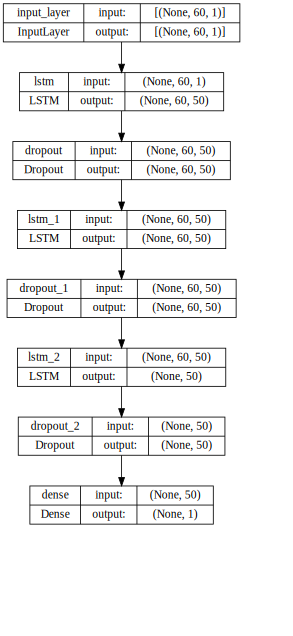

In [30]:
# Graphical plot:
iv1_dot = model_to_dot(model_lstm, 
                       show_shapes=True, 
                       show_layer_names=True, 
                       dpi=60)

SVG(iv1_dot.create(prog=['dot'], format='svg'))

In [20]:
# from keras.callbacks import ReduceLROnPlateau #Learning rate scheduler for when we reach plateaus

# rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)

In [21]:
tensorboard = TensorBoard(log_dir="neuronios/neuronio_150_{}".format(datetime.now()))

import time

StartTime = time.time()

history = model_lstm.fit(x_treino, 
                        y_treino,
                        epochs=6,
                        batch_size=32,
                        callbacks=[tensorboard], 
                        verbose=2)


EndTime = time.time()

print("\n## Tempo total gasto: ", round((EndTime-StartTime)/60), 'Minutos ##')

Epoch 1/6
28/28 - 108s - loss: 0.1224 - 108s/epoch - 4s/step
Epoch 2/6
28/28 - 123s - loss: 0.0844 - 123s/epoch - 4s/step
Epoch 3/6
28/28 - 91s - loss: 0.0834 - 91s/epoch - 3s/step
Epoch 4/6
28/28 - 100s - loss: 0.0837 - 100s/epoch - 4s/step
Epoch 5/6
28/28 - 132s - loss: 0.0813 - 132s/epoch - 5s/step
Epoch 6/6
28/28 - 179s - loss: 0.0812 - 179s/epoch - 6s/step

## Tempo total gasto:  12 Minutos ##


In [36]:
w = pd.DataFrame(history.history)

w.head(3)

,loss
0,0.122378
1,0.084392
2,0.083398


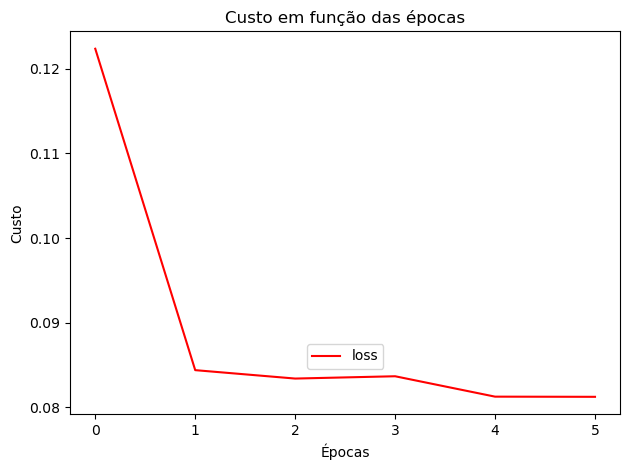

In [44]:
plt.plot(w['loss'], color='red', label='loss')
# plt.plot(history.history['val_loss'], color = 'black', label='val loss')
plt.title(f'Custo em função das épocas')
plt.ylabel('Custo')
plt.xlabel('Épocas')
plt.legend(bbox_to_anchor=(0.5, 0.1), loc='lower center')
plt.tight_layout()
plt.show()

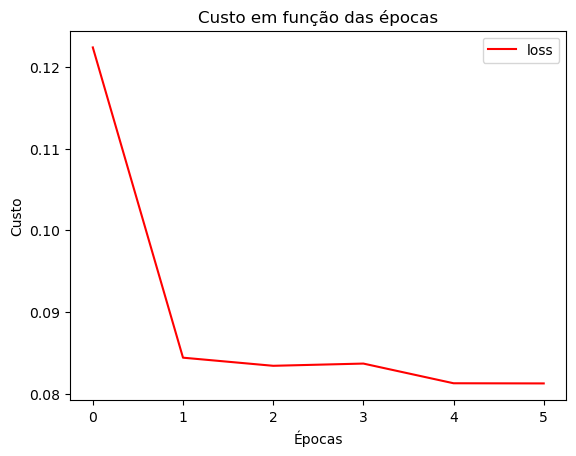

In [22]:
%matplotlib inline
plt.plot(history.history['loss'], color='red', label='loss')
# plt.plot(history.history['val_loss'], color = 'black', label='val loss')
plt.title(f'Custo em função das épocas')
plt.ylabel('Custo')
plt.xlabel('Épocas')
plt.legend(loc='best') 
# plt.savefig(f'neuronios/neuronio_150_{datetime.now()}.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>Avaliação do treino</h3>

In [23]:
valores_preditos = model_lstm.predict(x_teste) # aplicando o modelo treino no dados x_teste

valores_preditos_reais = normalizador.inverse_transform(valores_preditos)

rmse = np.sqrt(np.mean(valores_preditos_reais - y_teste)**2)

print(f"RSME:{rmse}")

8/8 [==============================] - 17s 2s/step
RSME:11108.99914293249


In [24]:
# Valores reais:

treino = data[:comprimento_treino]
print('\n## Dados de treino originais:', treino.shape)

validacao = data[comprimento_treino:]
print('\n## Dados de validação:',validacao.shape)

validacao['Predições'] = valores_preditos_reais
print('\n## Validação', validacao.shape)
validacao.tail(3)


## Dados de treino originais: (951, 1)

## Dados de validação: (237, 1)

## Validação (237, 2)


,close,Predições
2023-03-31,28478.484375,31753.558594
2023-04-01,28411.035156,31755.103516
2023-04-02,28199.308594,31756.027344


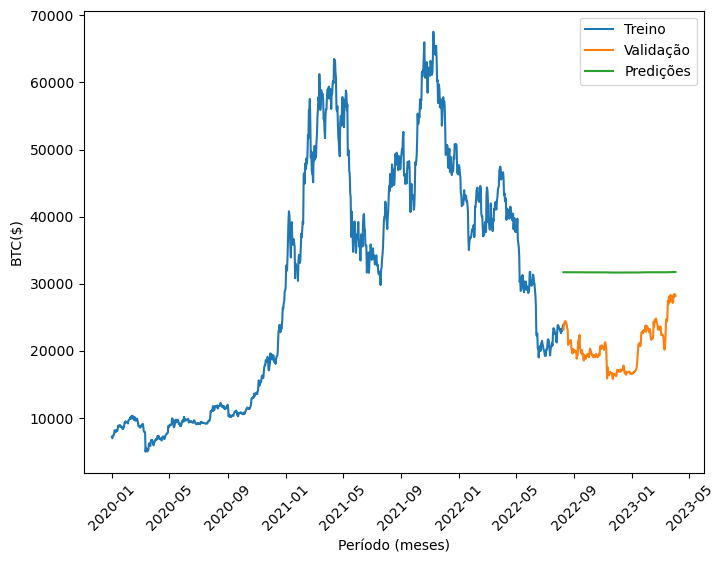

In [25]:
plt.figure(figsize=(8,6))
# plt.title('Model')
plt.xlabel('Período (meses)')
plt.ylabel('BTC($)')
plt.plot(treino)
plt.plot(validacao[['close', 'Predições']])
plt.xticks(rotation=45)
plt.legend(['Treino', 'Validação', 'Predições'], loc='best')
# plt.savefig(f'neuronios/neuronio_150_{datetime.now()}.png', dpi=300, bbox_inches='tight')
plt.show()

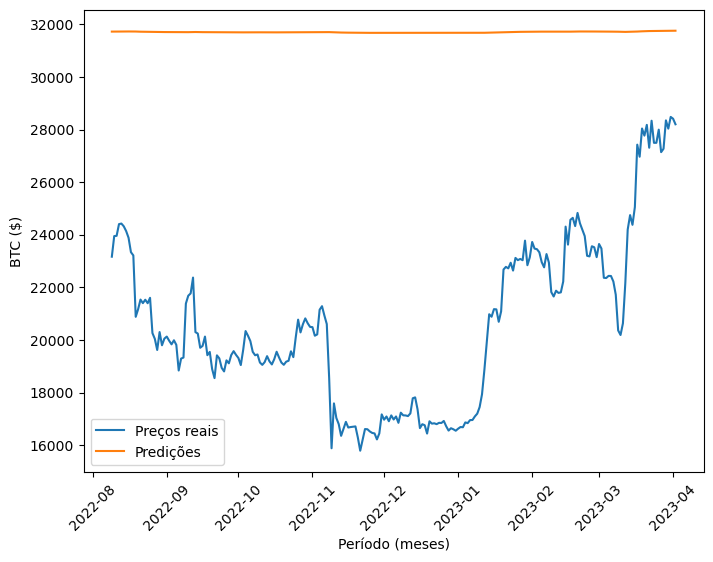

In [26]:
plt.figure(figsize=(8,6))
# plt.title('Model')
plt.xlabel('Período (meses)')
plt.ylabel('BTC ($)')
# plt.plot(treino)
plt.plot(validacao[['close', 'Predições']])
plt.xticks(rotation=45)
plt.legend(['Preços reais', 'Predições'], loc='best')
# plt.savefig(f'neuronios/neuronio_150_{datetime.now()}.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Parâmetros de extração dos dados
ATIVO = 'BTC-USD'
START_DATE = dt.datetime(2023,3,24)
END_DATE = dt.datetime(2023,4,3)
INTERVAL = '1d'

In [28]:
data = download_data(ATIVO, START_DATE, END_DATE)

data = data[['close']]

data.head(11)

,close
2023-03-24,27493.285156
2023-03-25,27494.707031
2023-03-26,27994.330078
2023-03-27,27139.888672
2023-03-28,27268.130859
2023-03-29,28348.441406
2023-03-30,28033.562500
2023-03-31,28478.484375
2023-04-01,28411.035156
2023-04-02,28199.308594


In [29]:
#Previsão dos proximos conjunto de valores de criptoativos:

# Last 10 days prices
Last10Days=np.array([27493.28515625, 27494.70703125, 
                     27994.33007812, 27139.88867188, 
                     27268.13085938, 28348.44140625, 
                     28033.5625, 28478.484375,
                     28411.03515625, 28199.30859375])
 
# Normalizing the data just like we did for training the model
Last10Days=normalizador.fit_transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = model_lstm.predict(Last10Days)
predicted_Price = normalizador.inverse_transform(predicted_Price)
predicted_Price

1/1 [==============================] - 2s 2s/step


array([[27733.838]], dtype=float32)